In [44]:
# Data & NLP Libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Save Model
import pickle

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       427482 non-null  object 
 1   news       427482 non-null  object 
 2   neg        427482 non-null  float64
 3   neu        427482 non-null  float64
 4   pos        427482 non-null  float64
 5   compound   427482 non-null  float64
 6   sentiment  427482 non-null  object 
dtypes: float64(4), object(3)
memory usage: 22.8+ MB
Missing values in each column:
date         0
news         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
dtype: int64

Sentiment Class Distribution (Training Set):
sentiment
NEGATIVE    217443
POSITIVE    210039
Name: count, dtype: int64

Sentiment Class Percentage:
sentiment
NEGATIVE    50.866001
POSITIVE    49.133999
Name: proportion, dtype: float64


/var/folders/5_/254j6xcn0mz_blnbzw9hhp3m0000gn/T/ipykernel_24868/822739686.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2', order=sentiment_counts.index)


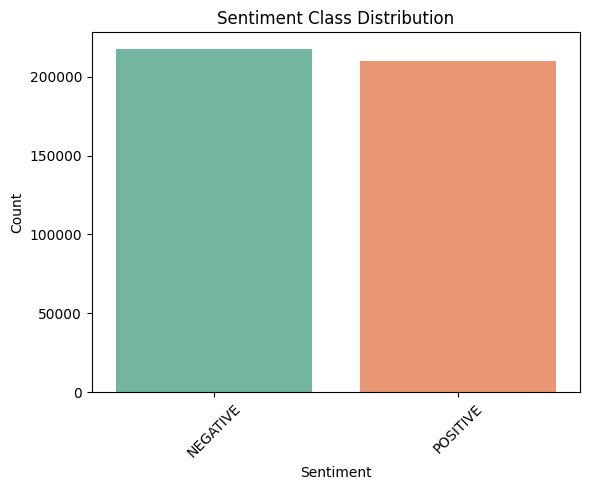

In [45]:
# Start code

# Read CSV file
df = pd.read_csv('news.csv')

# Display the first few rows
df.head()

# Show dataset information
df.info()

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Sentiment Class Distribution (Counts)
print("\nSentiment Class Distribution (Training Set):")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Sentiment Class Percentage
print("\nSentiment Class Percentage:")
sentiment_percentage = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_percentage)

# Visualize sentiment distribution
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='sentiment', palette='Set2', order=sentiment_counts.index)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# Function to clean text (Phase 1)
def clean_text_v1(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply first-level cleaning
df['clean_text'] = df['news'].apply(clean_text_v1)
df[['news', 'clean_text']].head()

,news,clean_text
0,It was a long antipodean night. While there’s ...,it was a long antipodean night while there’s n...
1,In Mexico there are no licensing or registrati...,in mexico there are no licensing or registrati...
2,The government has until Monday to protect the...,the government has until monday to protect the...
3,A record-breaking heat wave in the Southwest i...,a recordbreaking heat wave in the southwest is...
4,England started its Live Earth concert at Wemb...,england started its live earth concert at wemb...


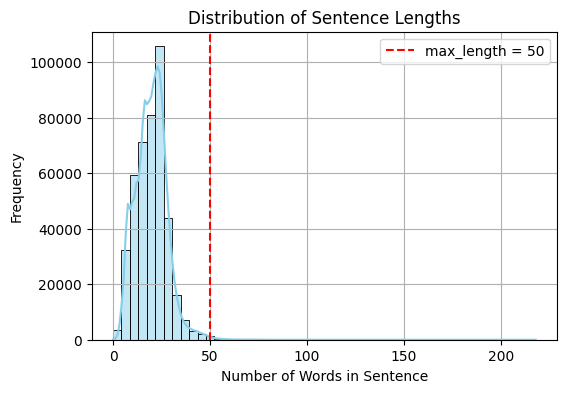

Sentence Length Statistics:
count    427482.000000
mean         19.834019
std           8.040432
min           0.000000
25%          14.000000
50%          20.000000
75%          25.000000
max         218.000000
Name: clean_text, dtype: float64


In [47]:
# Calculate sentence lengths (based on number of words)
sentence_lengths = df['clean_text'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
plt.figure(figsize=(6, 4))
sns.histplot(sentence_lengths, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words in Sentence')
plt.ylabel('Frequency')
plt.axvline(x=50, color='red', linestyle='--', label='max_length = 50')
plt.legend()
plt.grid(True)
plt.show()
# Show some statistics
print("Sentence Length Statistics:")
print(sentence_lengths.describe())

In [48]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') 

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenization
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(filtered_tokens)

# Apply tokenization and stopword removal
df['processed_text'] = df['clean_text'].apply(tokenize_and_remove_stopwords)

# Display processed text
df[['clean_text', 'processed_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wanjunxiao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wanjunxiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/wanjunxiao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,clean_text,processed_text
0,it was a long antipodean night while there’s n...,long antipodean night ’ telling ’ reflection n...
1,in mexico there are no licensing or registrati...,mexico licensing registration requirements rea...
2,the government has until monday to protect the...,government monday protect redacted names baseb...
3,a recordbreaking heat wave in the southwest is...,recordbreaking heat wave southwest pushing nor...
4,england started its live earth concert at wemb...,england started live earth concert wembley sta...


In [49]:
# Convert sentiment labels to numerical values (Positive -> 1, Negative -> 0)
df['sentiment'] = df['sentiment'].map({"POSITIVE": 1, "NEGATIVE": 0})

# Split the dataset into training and testing sets BEFORE vectorization
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.2, random_state=42
)

# Display dataset shape
X_train_raw.shape, X_test_raw.shape

((341985,), (85497,))

In [50]:
# ==== Cell A: Setup & utilities (run once) ====
import os, gzip, pickle, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, f1_score, balanced_accuracy_score, accuracy_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

RNG = 42
MODELS_DIR = pathlib.Path("models"); MODELS_DIR.mkdir(exist_ok=True)
REPORTS_DIR = pathlib.Path("reports"); REPORTS_DIR.mkdir(exist_ok=True)

def _save_pickle(obj, path):
    path = pathlib.Path(path); path.parent.mkdir(parents=True, exist_ok=True)
    with gzip.open(path, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"✅ Saved: {path}")

def _load_pickle(path):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

def _eval_and_report(name, y_true, proba, threshold=0.5, out_dir=REPORTS_DIR):
    y_pred = (proba >= threshold).astype(int)
    rep_df = pd.DataFrame(classification_report(
        y_true, y_pred, target_names=["NEG","POS"], output_dict=True, digits=4
    )).T
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro")
    try:
        auc  = roc_auc_score(y_true, proba)
    except Exception:
        auc  = np.nan

    print(f"\n=== {name} ===")
    print(rep_df[["precision","recall","f1-score","support"]])
    print(f"Accuracy={acc:.3f}  BalancedAcc={bacc:.3f}  MacroF1={f1m:.3f}  ROC-AUC={auc:.3f}")

    base = (out_dir / name.lower().replace(" ","_"))
    rep_df.to_csv(base.with_name(base.name + "_report.csv"))
    pd.DataFrame(cm, index=["ref_NEG","ref_POS"], columns=["pred_NEG","pred_POS"])\
      .to_csv(base.with_name(base.name + "_confusion.csv"))

    try:
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.figure(figsize=(4.2,3.6))
        plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],"--", color="#777")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {name} (AUC={auc:.3f})")
        plt.tight_layout(); plt.savefig(base.with_name(base.name + "_roc.png"), dpi=150); plt.close()
    except Exception:
        pass

    return {"acc":acc, "bacc":bacc, "macro_f1":f1m, "auc":auc}

def _tune_threshold(y_true, proba, metric="macro_f1", lo=0.2, hi=0.8, steps=61):
    best_thr, best_val = 0.5, -1
    for thr in np.linspace(lo, hi, steps):
        y_pred = (proba >= thr).astype(int)
        val = (balanced_accuracy_score(y_true, y_pred) if metric=="balanced_acc"
               else f1_score(y_true, y_pred, average="macro"))
        if val > best_val: best_val, best_thr = val, thr
    return best_thr, best_val

# ---- 数据切分（若你之前已切好，就会直接复用） ----
if 'X_train_raw' not in globals():
    assert 'df' in globals(), "请先准备好 df，并包含列 processed_text, sentiment(0/1)。"
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['processed_text'], df['sentiment'], test_size=0.2, random_state=RNG, stratify=df['sentiment']
    )

# 取训练集的 10% 作为阈值调优验证集
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.10, random_state=RNG, stratify=y_train
)

print("Shapes:",
      "\n  train:", X_train_raw.shape,
      "\n  test :", X_test_raw.shape,
      "\n  tr/val split:", X_tr.shape, X_val.shape)

Shapes: 
  train: (341985,) 
  test : (85497,) 
  tr/val split: (307786,) (34199,)


In [51]:
# ==== Cell B: TF-IDF + LogisticRegression ====
from sklearn.model_selection import GridSearchCV

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=2, max_df=0.98,
        strip_accents="unicode", lowercase=True, sublinear_tf=True,
        token_pattern=r"(?u)\b\w\w+\b"
    )),
    ("clf", LogisticRegression(
        max_iter=2000, class_weight="balanced",
        solver="liblinear", random_state=RNG
    ))
])

param_lr = {
    "tfidf__ngram_range": [(1,1),(1,2)],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
}

gs_lr = GridSearchCV(pipe_lr, param_lr, scoring="f1_macro", cv=3, n_jobs=1, verbose=1)
gs_lr.fit(X_tr, y_tr)
best_lr = gs_lr.best_estimator_
print("LR best params:", gs_lr.best_params_)

# 验证集阈值调优
proba_val_lr = best_lr.predict_proba(X_val)[:,1]
thr_lr, score_lr = _tune_threshold(y_val, proba_val_lr, metric="macro_f1")
print(f"★ LR tuned threshold = {thr_lr:.2f} (val macro-F1={score_lr:.3f})")

# 全量训练集拟合 & 测试评估
best_lr.fit(X_train_raw, y_train)
proba_test_lr = best_lr.predict_proba(X_test_raw)[:,1]
metrics_lr = _eval_and_report("LR_TFIDF (TEST)", y_test, proba_test_lr, threshold=thr_lr)

# 保存
_save_pickle({"model": best_lr, "threshold": thr_lr}, MODELS_DIR / "lr_tfidf.pkl.gz")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
LR best params: {'clf__C': 4.0, 'tfidf__ngram_range': (1, 1)}
★ LR tuned threshold = 0.49 (val macro-F1=0.879)

=== LR_TFIDF (TEST) ===
              precision    recall  f1-score       support
NEG            0.890806  0.867234  0.878862  43573.000000
POS            0.865706  0.889514  0.877449  41924.000000
accuracy       0.878159  0.878159  0.878159      0.878159
macro avg      0.878256  0.878374  0.878155  85497.000000
weighted avg   0.878498  0.878159  0.878169  85497.000000
Accuracy=0.878  BalancedAcc=0.878  MacroF1=0.878  ROC-AUC=0.949
✅ Saved: models/lr_tfidf.pkl.gz


In [34]:
# ==== Cell C: TF-IDF + LinearSVC (calibrated) ====
pipe_svc_raw = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=2, max_df=0.98,
        strip_accents="unicode", lowercase=True, sublinear_tf=True,
        token_pattern=r"(?u)\b\w\w+\b"
    )),
    ("svc", LinearSVC(class_weight="balanced", random_state=RNG))
])

param_svc = {
    "svc__C": [0.5, 1.0, 2.0],
    "tfidf__ngram_range": [(1,1),(1,2)],
}

gs_svc = GridSearchCV(pipe_svc_raw, param_svc, scoring="f1_macro", cv=3, n_jobs=1, verbose=1)
gs_svc.fit(X_tr, y_tr)
print("LinearSVC best params (pre-calibration):", gs_svc.best_params_)

# 用最优参数构造 pipeline，再做校准
pipe_svc_best = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=gs_svc.best_params_["tfidf__ngram_range"], min_df=2, max_df=0.98,
        strip_accents="unicode", lowercase=True, sublinear_tf=True,
        token_pattern=r"(?u)\b\w\w+\b"
    )),
    ("svc", LinearSVC(C=gs_svc.best_params_["svc__C"], class_weight="balanced", random_state=RNG))
])

svc_cal = CalibratedClassifierCV(estimator=pipe_svc_best, method="sigmoid", cv=3)
svc_cal.fit(X_tr, y_tr)

# 阈值调优
proba_val_svc = svc_cal.predict_proba(X_val)[:,1]
thr_svc, score_svc = _tune_threshold(y_val, proba_val_svc, metric="macro_f1")
print(f"★ SVC(sigmoid) tuned threshold = {thr_svc:.2f} (val macro-F1={score_svc:.3f})")

# 全量训练集拟合 & 测试评估
svc_cal.fit(X_train_raw, y_train)
proba_test_svc = svc_cal.predict_proba(X_test_raw)[:,1]
metrics_svc = _eval_and_report("SVC_TFIDF_CAL (TEST)", y_test, proba_test_svc, threshold=thr_svc)

# 保存
_save_pickle({"model": svc_cal, "threshold": thr_svc}, MODELS_DIR / "svc_tfidf_cal.pkl.gz")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
LinearSVC best params (pre-calibration): {'svc__C': 0.5, 'tfidf__ngram_range': (1, 1)}
★ SVC(sigmoid) tuned threshold = 0.47 (val macro-F1=0.876)

=== SVC_TFIDF_CAL (TEST) ===
              precision    recall  f1-score       support
NEG            0.891109  0.860739  0.875661  43573.000000
POS            0.860213  0.890683  0.875183  41924.000000
accuracy       0.875423  0.875423  0.875423      0.875423
macro avg      0.875661  0.875711  0.875422  85497.000000
weighted avg   0.875959  0.875423  0.875427  85497.000000
Accuracy=0.875  BalancedAcc=0.876  MacroF1=0.875  ROC-AUC=0.948
✅ Saved: models/svc_tfidf_cal.pkl.gz


In [11]:
# ==== Cell D: SBERT + LogisticRegression (CPU-optimized, with caching & threshold tuning) ====
import os, time, json, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             accuracy_score, balanced_accuracy_score, roc_auc_score,
                             cohen_kappa_score)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
from sentence_transformers import SentenceTransformer

# ---------- 0) 输入：沿用你前面准备好的 split；若不存在则从 df 重建 ----------
assert 'df' in globals(), "未发现 df，请先运行你上面的数据加载/清洗 cell，确保 df 在内存中。"
if not all(v in globals() for v in ['X_train_raw','X_test_raw','y_train','y_test']):
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        df['processed_text'], df['sentiment'],
        test_size=0.2, random_state=42, stratify=df['sentiment']
    )

# ---------- 1) 配置 ----------
SBERT_ID       = "sentence-transformers/all-MiniLM-L6-v2"   # 速度/效果平衡；更快可换 paraphrase-MiniLM-L3-v2
MAX_SEQ_LEN    = 128                                         # 控长度以提速（对新闻几乎无伤）
BATCH_SIZE     = 128                                         # 你的 16GB 内存 CPU 建议 96~192；OOM 就调小
C_GRID         = [0.5, 1.0, 2.0, 3.0]                        # 小网格足够稳定
VAL_SIZE       = 0.15                                        # 从训练中再切一份验证集，用于调参/阈值
CACHE_DIR      = Path("cache"); CACHE_DIR.mkdir(exist_ok=True)
MODEL_DIR      = Path("models"); MODEL_DIR.mkdir(exist_ok=True)
REPORT_DIR     = Path("reports/sbert_lr"); REPORT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cpu"  # 你的机型无 CUDA / MPS，强制 CPU 更稳
print(f"SBERT model: {SBERT_ID} | device={DEVICE} | max_len={MAX_SEQ_LEN} | bs={BATCH_SIZE}")

# ---------- 2) 初始化 SBERT ----------
sbert = SentenceTransformer(SBERT_ID, device=DEVICE)
sbert.max_seq_length = MAX_SEQ_LEN  # 限制长度提速

def _cache_name(prefix: str, series: pd.Series) -> Path:
    """根据文本规模和少量内容做个轻量哈希，避免误读旧缓存。"""
    sample = "|".join(series.astype(str).head(50).tolist())
    sig = hashlib.md5(f"{len(series)}|{len(sample)}|{hashlib.md5(sample.encode()).hexdigest()}".encode()).hexdigest()[:10]
    return CACHE_DIR / f"{prefix}_{sig}.npy"

def embed(texts: pd.Series, prefix: str) -> np.ndarray:
    cache_path = _cache_name(prefix, texts)
    if cache_path.exists():
        arr = np.load(cache_path)
        if arr.shape[0] == len(texts):
            print(f"→ loaded cached embeddings: {cache_path.name} {arr.shape}")
            return arr
    print(f"→ encoding {len(texts):,} texts (will cache to {cache_path.name}) ...")
    t0 = time.perf_counter()
    vecs = []
    L = len(texts)
    for i in range(0, L, BATCH_SIZE):
        batch = texts.iloc[i:i+BATCH_SIZE].tolist()
        v = sbert.encode(batch,
                         batch_size=min(BATCH_SIZE, len(batch)),
                         convert_to_numpy=True,
                         show_progress_bar=False,
                         normalize_embeddings=True)  # 归一化便于 LR 收敛
        vecs.append(v)
    arr = np.vstack(vecs)
    np.save(cache_path, arr)
    print(f"  done in {time.perf_counter()-t0:.1f}s -> {arr.shape}")
    return arr

# ---------- 3) 训练/验证/测试拆分 ----------
Xtr_raw, Xva_raw, ytr, yva = train_test_split(
    pd.Series(X_train_raw), pd.Series(y_train),
    test_size=VAL_SIZE, random_state=42, stratify=y_train
)
# 向量化（带缓存）
Xtr = embed(Xtr_raw, prefix="sbert_Xtr")
Xva = embed(Xva_raw, prefix="sbert_Xva")
Xte = embed(pd.Series(X_test_raw), prefix="sbert_Xte")

# ---------- 4) 小网格搜索 C（验证集宏 F1 最大） ----------
best = {"C": None, "f1": -1, "model": None}
for C in C_GRID:
    clf = LogisticRegression(
        C=C, class_weight="balanced", solver="liblinear", max_iter=2000, n_jobs=None
    )
    clf.fit(Xtr, ytr)
    p_va = clf.predict_proba(Xva)[:, 1]
    # 先用 0.5 粗评估
    f1 = f1_score(yva, (p_va >= 0.5).astype(int), average="macro")
    print(f"C={C:<4} | val macro-F1={f1:.4f}")
    if f1 > best["f1"]:
        best.update({"C": C, "f1": f1, "model": clf})

print(f"★ best C on val = {best['C']} (macro-F1={best['f1']:.4f})")

# ---------- 5) 在验证集上调阈值（宏 F1 最大） ----------
p_va = best["model"].predict_proba(Xva)[:, 1]
ths = np.linspace(0.2, 0.8, 61)
scores = [f1_score(yva, (p_va>=t).astype(int), average="macro") for t in ths]
best_th = ths[int(np.argmax(scores))]
print(f"★ tuned POS threshold on val = {best_th:.2f} (macro-F1={max(scores):.4f})")

# ---------- 6) 在“训练+验证”上重训最终模型 ----------
Xtrva = np.vstack([Xtr, Xva])
ytrva = np.concatenate([ytr.values, yva.values])
final_clf = LogisticRegression(
    C=best["C"], class_weight="balanced", solver="liblinear", max_iter=3000
).fit(Xtrva, ytrva)

# ---------- 7) 测试集评估 ----------
p_te = final_clf.predict_proba(Xte)[:, 1]
yhat05 = (p_te >= 0.5).astype(int)
yhatT  = (p_te >= best_th).astype(int)

def _report(y_true, y_pred, tag: str):
    print(f"\n=== SBERT+LR ({tag}) on TEST ===")
    print(classification_report(y_true, y_pred, digits=3))
    kappa  = cohen_kappa_score(y_true, y_pred)
    acc    = accuracy_score(y_true, y_pred)
    bacc   = balanced_accuracy_score(y_true, y_pred)
    f1m    = f1_score(y_true, y_pred, average="macro")
    auc    = roc_auc_score(y_true, p_te) if len(np.unique(y_true))==2 else np.nan
    print(f"Kappa={kappa:.3f}  Acc={acc:.3f}  B-Acc={bacc:.3f}  Macro-F1={f1m:.3f}  ROC-AUC={auc:.3f}")
    # 保存报告
    rep = classification_report(y_true, y_pred, output_dict=True)
    pd.DataFrame(rep).T.to_csv(REPORT_DIR/f"report_{tag}.csv")
    pd.DataFrame(confusion_matrix(y_true, y_pred),
                 index=["ref_0","ref_1"], columns=["pred_0","pred_1"]).to_csv(REPORT_DIR/f"confusion_{tag}.csv")

_report(y_test, yhat05, "thr0.50")
_report(y_test, yhatT,  "thrTuned")

# ---------- 8) 保存模型（权重 + 配置；SBERT 只存 ID，推理时按同 ID 重新载入） ----------
MODEL_PATH = MODEL_DIR / "sbert_lr.joblib"
ARTIFACT = {
    "clf": final_clf,
    "sbert_id": SBERT_ID,
    "max_seq_len": MAX_SEQ_LEN,
    "normalize_embeddings": True,
    "threshold": float(best_th),
    "created_at": pd.Timestamp.now().isoformat()
}
dump(ARTIFACT, MODEL_PATH)
with open(MODEL_DIR/"sbert_lr_meta.json","w") as f:
    json.dump({k:(float(v) if isinstance(v,np.floating) else v) for k,v in ARTIFACT.items() if k!="clf"}, f, indent=2)
print(f"\n✅ Saved model to: {MODEL_PATH}")
print(f"📄 Reports → {REPORT_DIR}")


SBERT model: sentence-transformers/all-MiniLM-L6-v2 | device=cpu | max_len=128 | bs=128
→ encoding 290,687 texts (will cache to sbert_Xtr_9ca8001a3d.npy) ...
  done in 1879.8s -> (290687, 384)
→ encoding 51,298 texts (will cache to sbert_Xva_109eebd709.npy) ...
  done in 382.6s -> (51298, 384)
→ encoding 85,497 texts (will cache to sbert_Xte_011e818113.npy) ...
  done in 629.3s -> (85497, 384)
C=0.5  | val macro-F1=0.7746
C=1.0  | val macro-F1=0.7746
C=2.0  | val macro-F1=0.7746
C=3.0  | val macro-F1=0.7746
★ best C on val = 0.5 (macro-F1=0.7746)
★ tuned POS threshold on val = 0.48 (macro-F1=0.7747)

=== SBERT+LR (thr0.50) on TEST ===
              precision    recall  f1-score   support

           0      0.784     0.773     0.779     43573
           1      0.768     0.779     0.773     41924

    accuracy                          0.776     85497
   macro avg      0.776     0.776     0.776     85497
weighted avg      0.776     0.776     0.776     85497

Kappa=0.552  Acc=0.776  B-Acc=

Device: cpu
Loading model: yiyanghkust/finbert-tone
Model loaded successfully
Model label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
→ FinBERT inference in progress...

FinBERT Binary Classification Performance:
              precision    recall  f1-score   support

           0       0.49      0.77      0.60     43573
           1       0.43      0.18      0.25     41924

    accuracy                           0.48     85497
   macro avg       0.46      0.48      0.43     85497
weighted avg       0.46      0.48      0.43     85497

Accuracy: 0.4817

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               33606                9967
Actual Positive               34345                7579


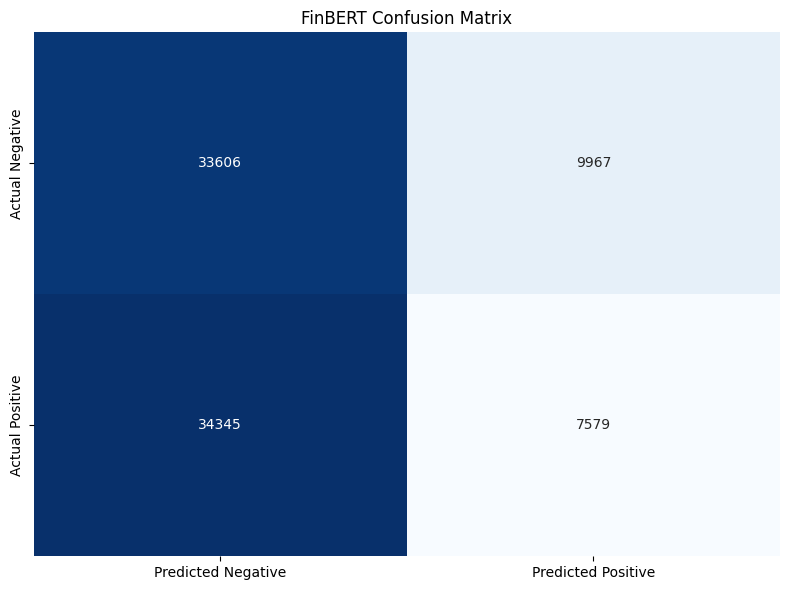

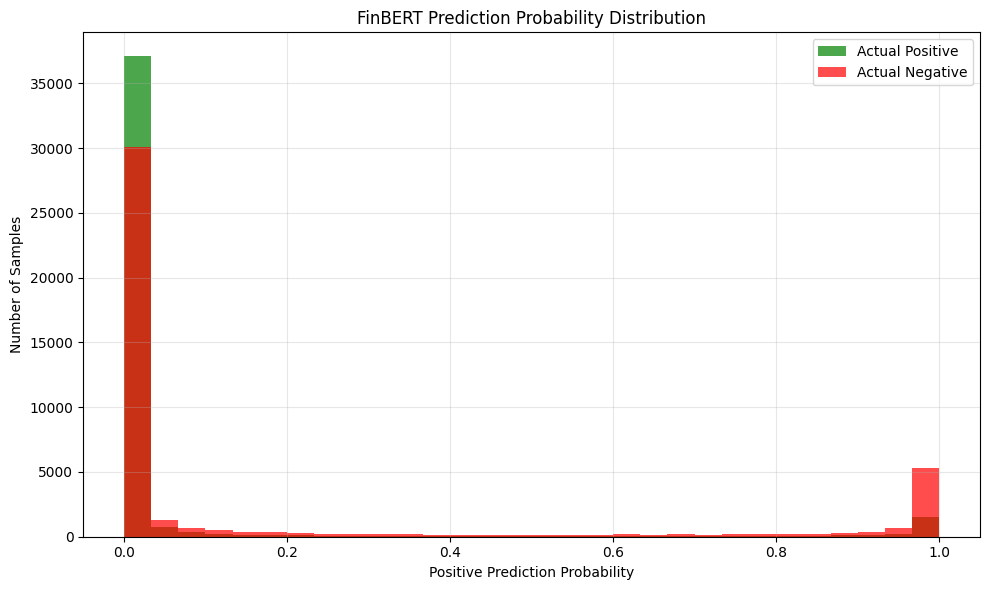


Performance with different thresholds:
Threshold 0.1: Accuracy=0.4196, F1-Score=0.1321
Threshold 0.2: Accuracy=0.4276, F1-Score=0.1178
Threshold 0.3: Accuracy=0.4325, F1-Score=0.1105
Threshold 0.4: Accuracy=0.4363, F1-Score=0.1038
Threshold 0.5: Accuracy=0.4395, F1-Score=0.0978
Threshold 0.6: Accuracy=0.4429, F1-Score=0.0929
Threshold 0.7: Accuracy=0.4468, F1-Score=0.0876
Threshold 0.8: Accuracy=0.4511, F1-Score=0.0811
Threshold 0.9: Accuracy=0.4569, F1-Score=0.0724

Best threshold: 0.10
Performance with best threshold:
              precision    recall  f1-score   support

           0       0.46      0.74      0.56     43573
           1       0.25      0.09      0.13     41924

    accuracy                           0.42     85497
   macro avg       0.35      0.41      0.35     85497
weighted avg       0.35      0.42      0.35     85497


✅ Model info saved: models/finbert_model_info.joblib

Number of misclassified samples: 44312

First 10 misclassified samples:
Text: almost us def

In [52]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# Create output directories
REPORT_DIR = Path("reports/finbert")
MODEL_DIR = Path("models")
REPORT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Use financial sentiment analysis model
FINBERT_ID = "yiyanghkust/finbert-tone"  # This is a three-class model
print(f"Loading model: {FINBERT_ID}")

try:
    tok = AutoTokenizer.from_pretrained(FINBERT_ID)
    net = AutoModelForSequenceClassification.from_pretrained(FINBERT_ID, use_safetensors=True).to(device).eval()
    print("Model loaded successfully")
except Exception as e:
    print(f"Model loading failed: {e}")
    # If the above model fails, try an alternative model
    FINBERT_ID = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
    print(f"Trying alternative model: {FINBERT_ID}")
    tok = AutoTokenizer.from_pretrained(FINBERT_ID)
    net = AutoModelForSequenceClassification.from_pretrained(FINBERT_ID).to(device).eval()

# Model label mapping - corrected to three classes
ID2LBL = {0: "Negative", 1: "Neutral", 2: "Positive"}
print("Model label mapping:", ID2LBL)

@torch.inference_mode()
def finbert_predict(texts, bs=32, max_len=128):
    """
    Perform batch prediction using FinBERT model, return predicted labels and probabilities
    """
    labs = []
    probs = []
    for i in range(0, len(texts), bs):
        batch_texts = texts[i:i+bs]
        enc = tok(
            batch_texts, 
            truncation=True, 
            padding=True, 
            max_length=max_len, 
            return_tensors="pt"
        ).to(device)
        
        outputs = net(**enc)
        logits = outputs.logits
        batch_probs = torch.softmax(logits, dim=-1)
        batch_preds = torch.argmax(batch_probs, dim=-1)
        
        labs.extend([ID2LBL[p.item()] for p in batch_preds])
        probs.extend(batch_probs.detach().cpu().numpy())
    
    return labs, np.array(probs)

print("→ FinBERT inference in progress...")
pred_labels, pred_probs = finbert_predict(X_test_raw.tolist(), bs=32)

# Convert three-class to binary classification
# Method 1: Treat Neutral as Positive
pred_labels_binary = ["Positive" if label == "Neutral" else label for label in pred_labels]

# Method 2: Reassign based on probability threshold
# positive_probs = pred_probs[:, 1] + pred_probs[:, 2]  # Neutral + Positive
# pred_labels_binary = ["Positive" if p > 0.5 else "Negative" for p in positive_probs]

# Use first method
y_pred = [1 if label == "Positive" else 0 for label in pred_labels_binary]
positive_probs = pred_probs[:, 2]  # Positive class probability

# Evaluate model performance
print("\nFinBERT Binary Classification Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Negative', 'Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])

print("\nConfusion Matrix:")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('FinBERT Confusion Matrix')
plt.tight_layout()
plt.savefig(REPORT_DIR / "finbert_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot probability distribution
plt.figure(figsize=(10, 6))

# Probability distribution for positive class samples
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]

plt.hist(positive_probs[positive_indices], bins=30, alpha=0.7, label='Actual Positive', color='green')
plt.hist(positive_probs[negative_indices], bins=30, alpha=0.7, label='Actual Negative', color='red')

plt.xlabel('Positive Prediction Probability')
plt.ylabel('Number of Samples')
plt.title('FinBERT Prediction Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPORT_DIR / "finbert_probability_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Try different probability thresholds
print("\nPerformance with different thresholds:")
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for threshold in thresholds:
    y_pred_thresh = (positive_probs >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append((threshold, acc, f1))
    print(f"Threshold {threshold:.1f}: Accuracy={acc:.4f}, F1-Score={f1:.4f}")

# Find the best threshold
best_threshold = max(results, key=lambda x: x[2])[0]
y_pred_best = (positive_probs >= best_threshold).astype(int)

print(f"\nBest threshold: {best_threshold:.2f}")
print("Performance with best threshold:")
print(classification_report(y_test, y_pred_best))

# Save results
results_df = pd.DataFrame({
    'text': X_test_raw,
    'true_label': y_test,
    'pred_label': y_pred,
    'pred_prob': positive_probs,
    'best_threshold_pred': y_pred_best
})

results_df.to_csv(REPORT_DIR / "finbert_predictions.csv", index=False)

# Save model information
model_info = {
    'model_id': FINBERT_ID,
    'device': device,
    'best_threshold': best_threshold,
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred)
}

dump(model_info, MODEL_DIR / "finbert_model_info.joblib")
print(f"\n✅ Model info saved: {MODEL_DIR / 'finbert_model_info.joblib'}")

# Error analysis: examine misclassified samples
misclassified = results_df[results_df['true_label'] != results_df['pred_label']]
print(f"\nNumber of misclassified samples: {len(misclassified)}")
print("\nFirst 10 misclassified samples:")
for i, row in misclassified.head(10).iterrows():
    print(f"Text: {row['text'][:100]}...")
    print(f"True label: {'Positive' if row['true_label'] == 1 else 'Negative'}")
    print(f"Predicted label: {'Positive' if row['pred_label'] == 1 else 'Negative'}")
    print(f"Prediction probability: {row['pred_prob']:.4f}")
    print("-" * 50)

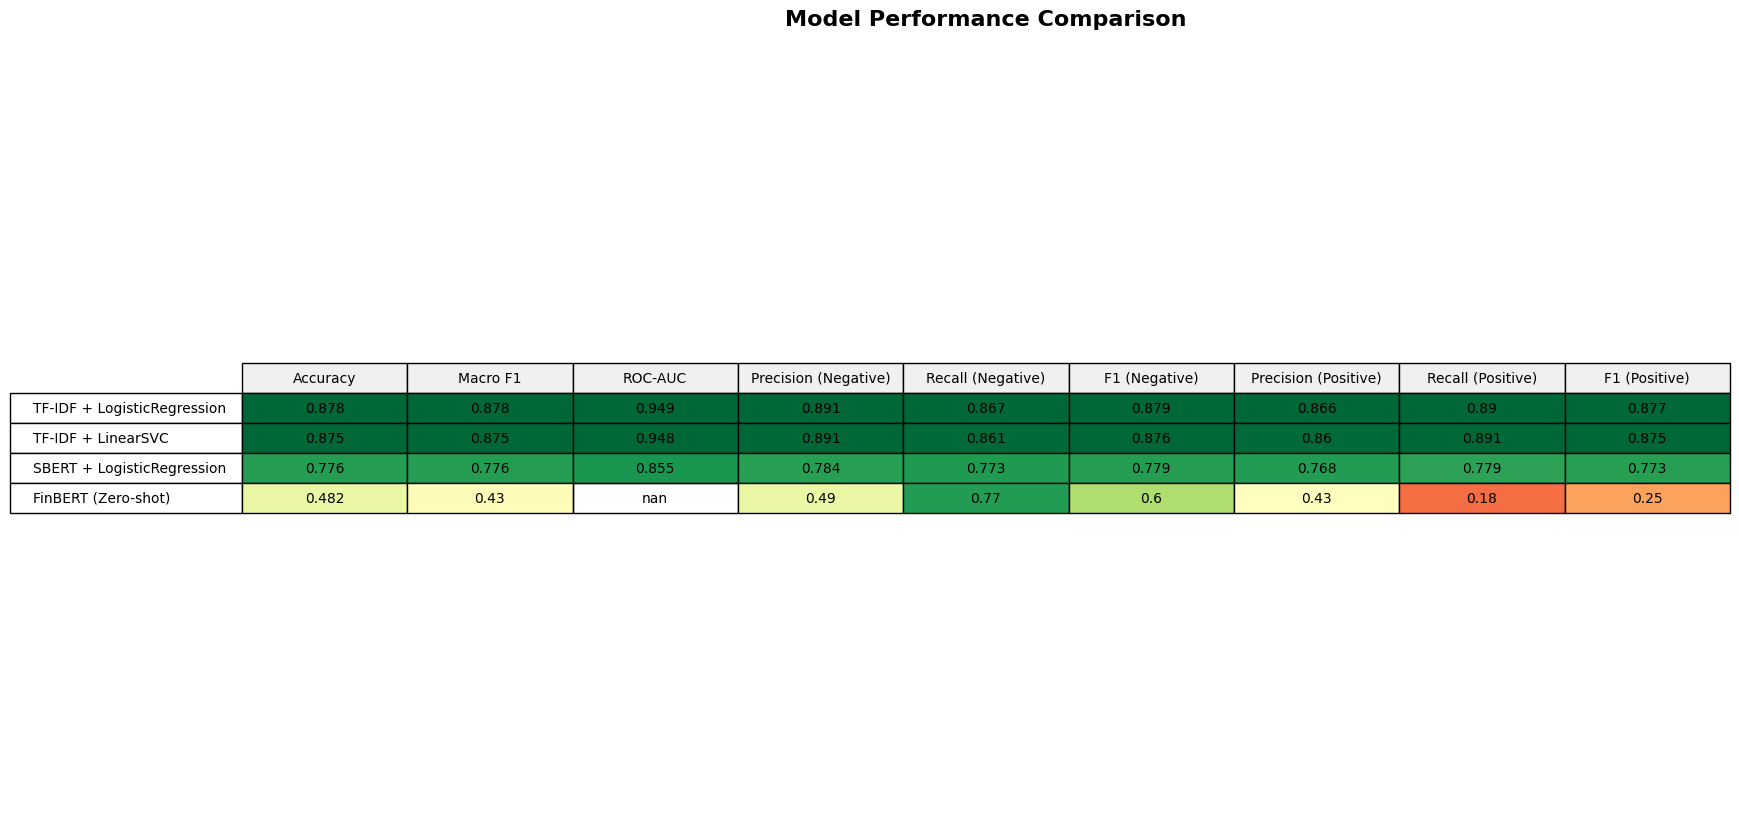

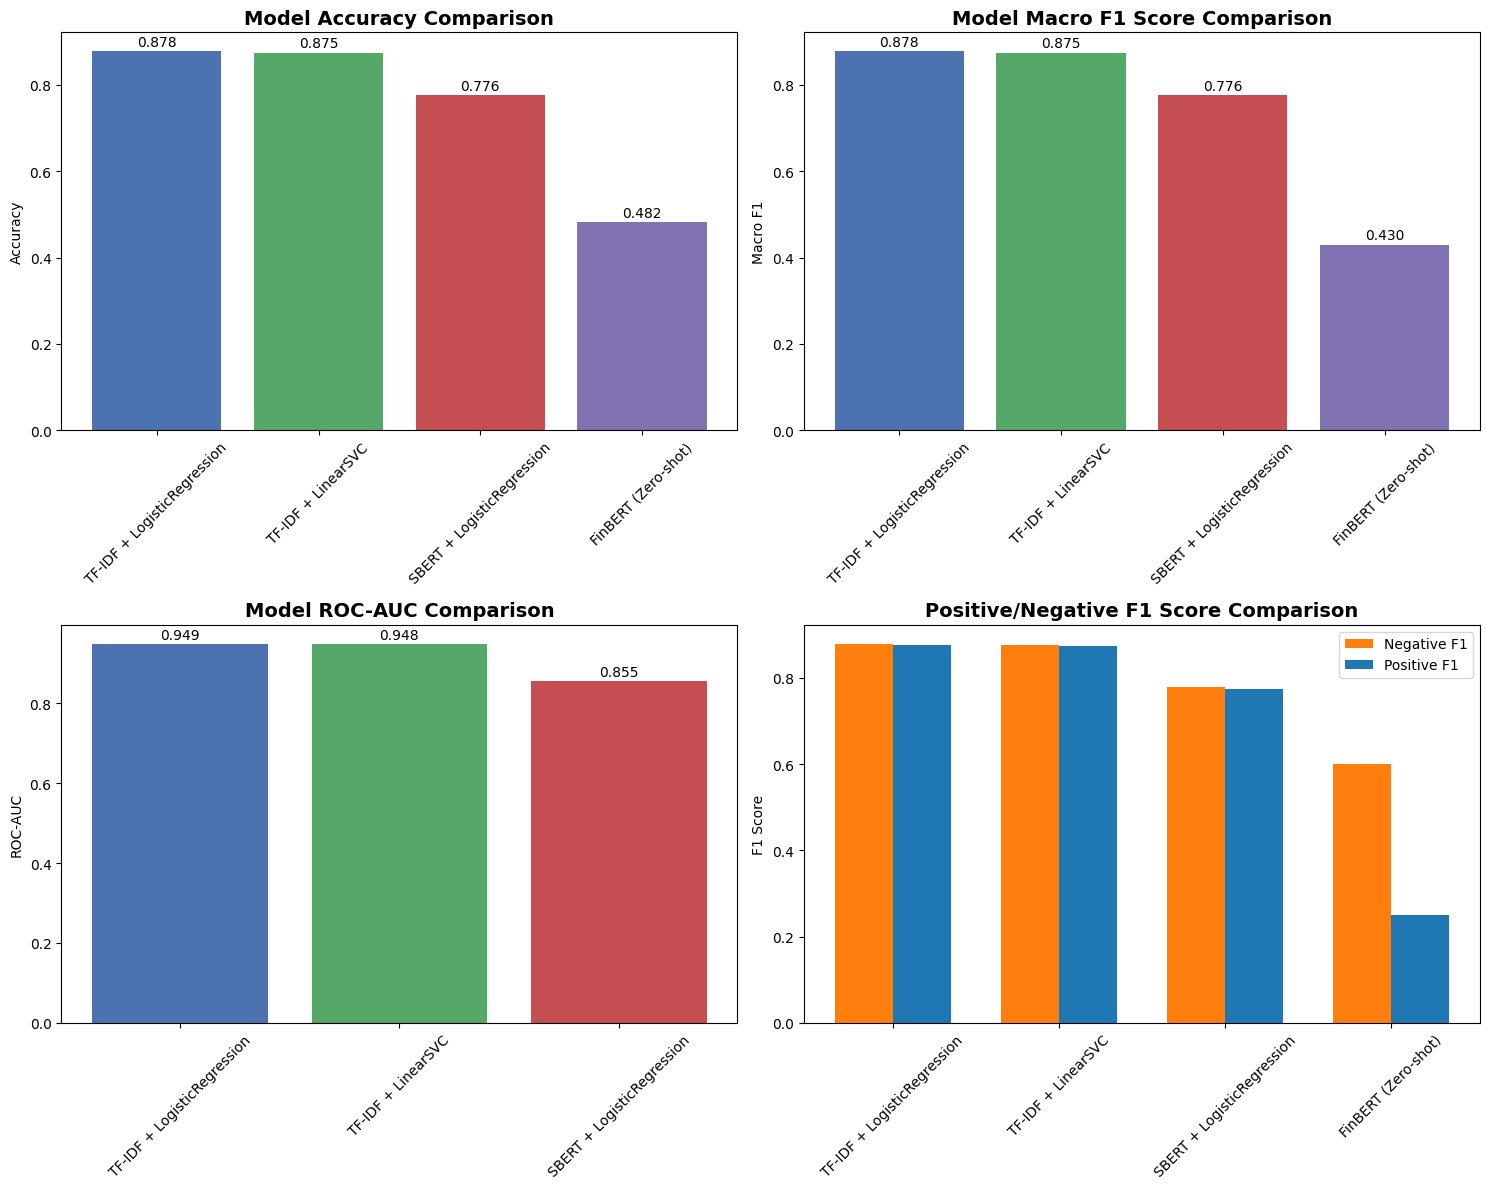

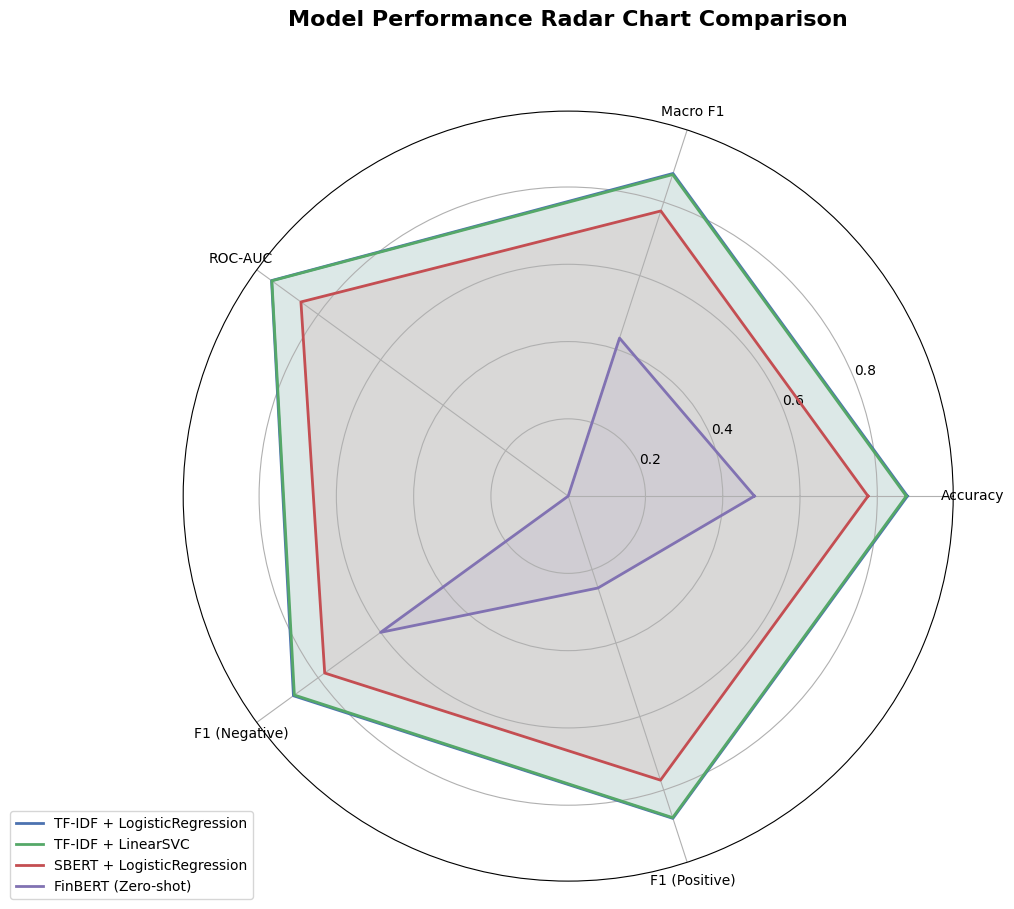

Model Performance Summary:
TF-IDF + LogisticRegression:
  Accuracy: 0.878
  Macro F1: 0.878
  ROC-AUC: 0.949
  Negative F1: 0.879
  Positive F1: 0.877
----------------------------------------
TF-IDF + LinearSVC:
  Accuracy: 0.875
  Macro F1: 0.875
  ROC-AUC: 0.948
  Negative F1: 0.876
  Positive F1: 0.875
----------------------------------------
SBERT + LogisticRegression:
  Accuracy: 0.776
  Macro F1: 0.776
  ROC-AUC: 0.855
  Negative F1: 0.779
  Positive F1: 0.773
----------------------------------------
FinBERT (Zero-shot):
  Accuracy: 0.482
  Macro F1: 0.430
  Negative F1: 0.600
  Positive F1: 0.250
----------------------------------------

Best Performing Models:
  Highest Accuracy: TF-IDF + LogisticRegression (0.878)
  Highest Macro F1: TF-IDF + LogisticRegression (0.878)
  Highest ROC-AUC: TF-IDF + LogisticRegression (0.949)

Detailed results saved to 'model_comparison_results.csv'


In [54]:
# Create a comparison table for all four models
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Model performance data
model_data = {
    'Model': ['TF-IDF + LogisticRegression', 'TF-IDF + LinearSVC', 'SBERT + LogisticRegression', 'FinBERT (Zero-shot)'],
    'Accuracy': [0.878, 0.875, 0.776, 0.482],
    'Macro F1': [0.878, 0.875, 0.776, 0.430],
    'ROC-AUC': [0.949, 0.948, 0.855, None],
    'Precision (Negative)': [0.891, 0.891, 0.784, 0.490],
    'Recall (Negative)': [0.867, 0.861, 0.773, 0.770],
    'F1 (Negative)': [0.879, 0.876, 0.779, 0.600],
    'Precision (Positive)': [0.866, 0.860, 0.768, 0.430],
    'Recall (Positive)': [0.890, 0.891, 0.779, 0.180],
    'F1 (Positive)': [0.877, 0.875, 0.773, 0.250]
}

# Create DataFrame
df_models = pd.DataFrame(model_data)

# Set model as index
df_models.set_index('Model', inplace=True)

# Create performance comparison table
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

# Create custom colormap
cmap = LinearSegmentedColormap.from_list('my_cmap', ['#ffcccc', '#ccffcc'])

# Create table
table = ax.table(cellText=df_models.round(3).values,
                 rowLabels=df_models.index,
                 colLabels=df_models.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=['#f0f0f0']*len(df_models.columns),
                 cellColours=plt.cm.RdYlGn(df_models.values/np.nanmax(df_models.values, axis=0)))

# Set table style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Add title
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)

# Save table
plt.savefig('model_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Create visualization of main metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].bar(df_models.index, df_models['Accuracy'], color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_models['Accuracy']):
    axes[0, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# Macro F1 comparison
axes[0, 1].bar(df_models.index, df_models['Macro F1'], color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])
axes[0, 1].set_title('Model Macro F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Macro F1')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_models['Macro F1']):
    axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# ROC-AUC comparison (exclude FinBERT)
roc_models = df_models[df_models.index != 'FinBERT (Zero-shot)']
axes[1, 0].bar(roc_models.index, roc_models['ROC-AUC'], color=['#4c72b0', '#55a868', '#c44e52'])
axes[1, 0].set_title('Model ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(roc_models['ROC-AUC']):
    axes[1, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# Positive/Negative F1 score comparison
width = 0.35
x = np.arange(len(df_models.index))
axes[1, 1].bar(x - width/2, df_models['F1 (Negative)'], width, label='Negative F1', color='#ff7f0e')
axes[1, 1].bar(x + width/2, df_models['F1 (Positive)'], width, label='Positive F1', color='#1f77b4')
axes[1, 1].set_title('Positive/Negative F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(df_models.index, rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

# Create radar chart for main metrics
categories = ['Accuracy', 'Macro F1', 'ROC-AUC', 'F1 (Negative)', 'F1 (Positive)']
N = len(categories)

# Create data for each model
values = {}
for model in df_models.index:
    model_vals = [
        df_models.loc[model, 'Accuracy'],
        df_models.loc[model, 'Macro F1'],
        df_models.loc[model, 'ROC-AUC'] if not pd.isna(df_models.loc[model, 'ROC-AUC']) else 0,
        df_models.loc[model, 'F1 (Negative)'],
        df_models.loc[model, 'F1 (Positive)']
    ]
    values[model] = model_vals

# Create radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Calculate coordinates for each angle
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the radar chart

# Plot each model's radar chart
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']
for idx, (model, vals) in enumerate(values.items()):
    vals += vals[:1]  # Close the radar chart
    ax.plot(angles, vals, linewidth=2, linestyle='solid', label=model, color=colors[idx])
    ax.fill(angles, vals, alpha=0.1, color=colors[idx])

# Add category labels
ax.set_thetagrids(np.degrees(angles[:-1]), categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Add title
plt.title('Model Performance Radar Chart Comparison', size=16, fontweight='bold', y=1.1)

plt.savefig('model_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance summary
print("Model Performance Summary:")
print("=" * 60)
for model in df_models.index:
    print(f"{model}:")
    print(f"  Accuracy: {df_models.loc[model, 'Accuracy']:.3f}")
    print(f"  Macro F1: {df_models.loc[model, 'Macro F1']:.3f}")
    if not pd.isna(df_models.loc[model, 'ROC-AUC']):
        print(f"  ROC-AUC: {df_models.loc[model, 'ROC-AUC']:.3f}")
    print(f"  Negative F1: {df_models.loc[model, 'F1 (Negative)']:.3f}")
    print(f"  Positive F1: {df_models.loc[model, 'F1 (Positive)']:.3f}")
    print("-" * 40)

# Determine best models
best_accuracy = df_models['Accuracy'].idxmax()
best_f1 = df_models['Macro F1'].idxmax()
best_auc = df_models['ROC-AUC'].idxmax() if not df_models['ROC-AUC'].isna().all() else "N/A"

print(f"\nBest Performing Models:")
print(f"  Highest Accuracy: {best_accuracy} ({df_models.loc[best_accuracy, 'Accuracy']:.3f})")
print(f"  Highest Macro F1: {best_f1} ({df_models.loc[best_f1, 'Macro F1']:.3f})")
if best_auc != "N/A":
    print(f"  Highest ROC-AUC: {best_auc} ({df_models.loc[best_auc, 'ROC-AUC']:.3f})")

# Save detailed results to CSV
df_models.to_csv('model_comparison_results.csv')
print("\nDetailed results saved to 'model_comparison_results.csv'")

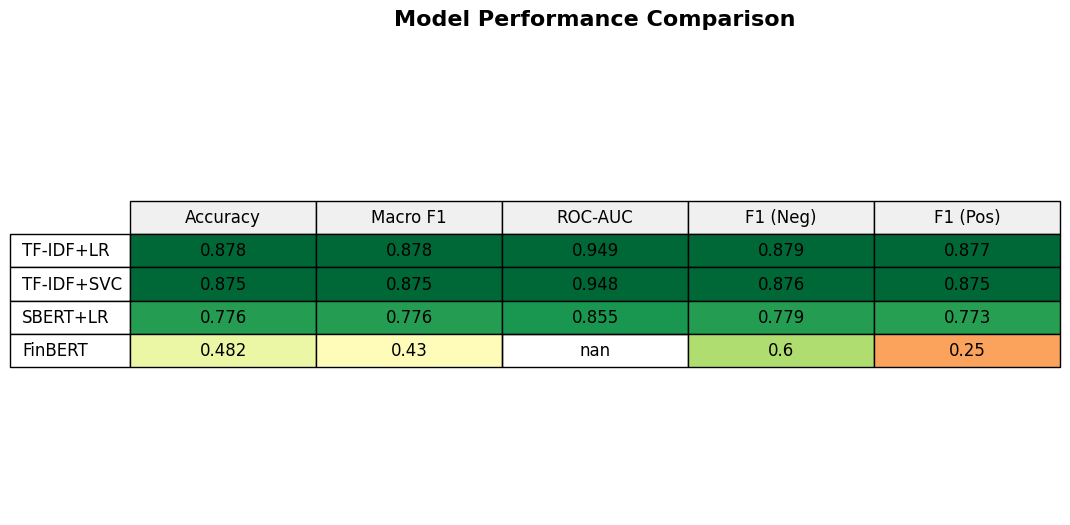

Model Performance Comparison Table:
Model           Accuracy   Macro F1   ROC-AUC    F1 (Neg)   F1 (Pos)  
------------------------------------------------------------
TF-IDF+LR       0.878      0.878      0.949      0.879      0.877     
TF-IDF+SVC      0.875      0.875      0.948      0.876      0.875     
SBERT+LR        0.776      0.776      0.855      0.779      0.773     
FinBERT         0.482      0.430      N/A        0.600      0.250     


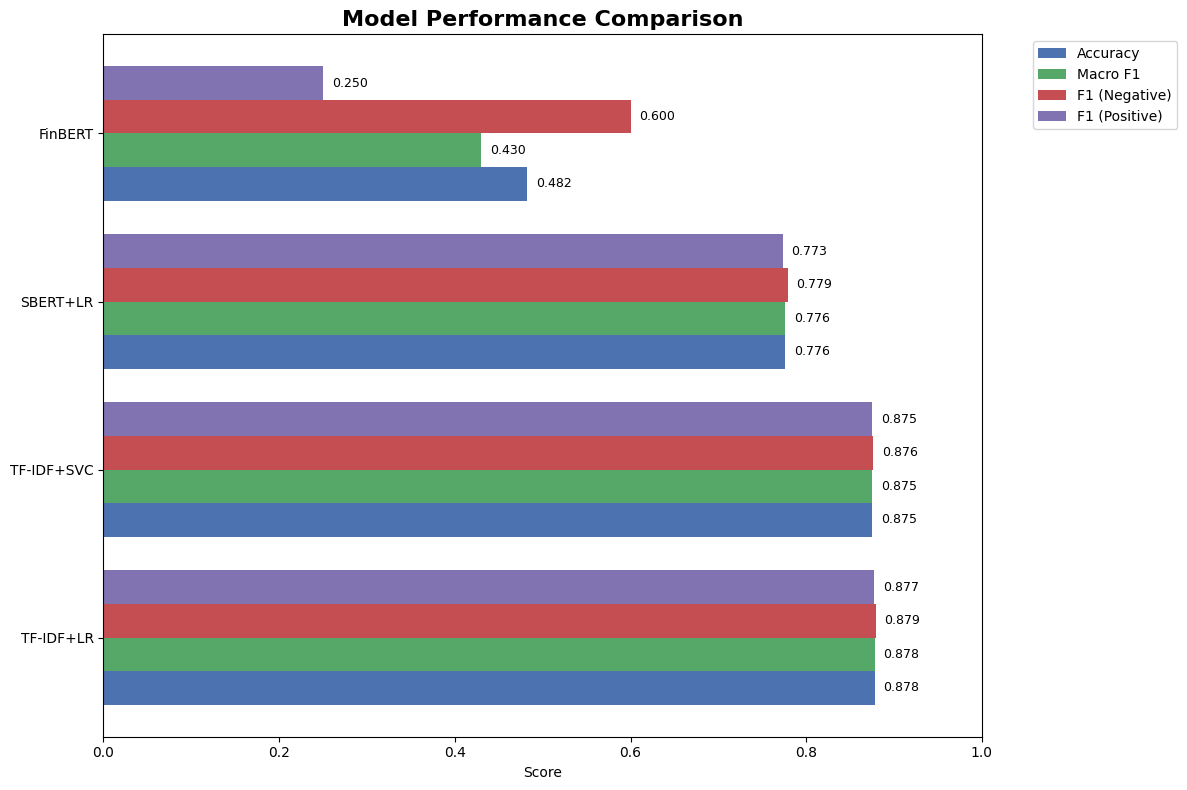


Performance Summary:
Best Accuracy: TF-IDF+LR (0.878)
Best Macro F1: TF-IDF+LR (0.878)
Best ROC-AUC: TF-IDF+LR (0.949)
Best F1 (Negative): TF-IDF+LR (0.879)
Best F1 (Positive): TF-IDF+LR (0.877)


In [55]:
# Create a compact comparison table for all four models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Model performance data with compact structure
model_data = {
    'Model': ['TF-IDF+LR', 'TF-IDF+SVC', 'SBERT+LR', 'FinBERT'],
    'Accuracy': [0.878, 0.875, 0.776, 0.482],
    'Macro F1': [0.878, 0.875, 0.776, 0.430],
    'ROC-AUC': [0.949, 0.948, 0.855, None],
    'F1 (Neg)': [0.879, 0.876, 0.779, 0.600],
    'F1 (Pos)': [0.877, 0.875, 0.773, 0.250]
}

# Create DataFrame
df_compact = pd.DataFrame(model_data)

# Set model as index
df_compact.set_index('Model', inplace=True)

# Create compact performance comparison table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=df_compact.round(3).values,
                 rowLabels=df_compact.index,
                 colLabels=df_compact.columns,
                 cellLoc='center',
                 loc='center',
                 colColours=['#f0f0f0']*len(df_compact.columns),
                 cellColours=plt.cm.RdYlGn(df_compact.values/np.nanmax(df_compact.values, axis=0)))

# Set table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2.0)

# Add title
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)

# Save table
plt.savefig('compact_model_comparison_table.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the table to console
print("Model Performance Comparison Table:")
print("=" * 60)
print(f"{'Model':<15} {'Accuracy':<10} {'Macro F1':<10} {'ROC-AUC':<10} {'F1 (Neg)':<10} {'F1 (Pos)':<10}")
print("-" * 60)
for model in df_compact.index:
    acc = f"{df_compact.loc[model, 'Accuracy']:.3f}"
    f1 = f"{df_compact.loc[model, 'Macro F1']:.3f}"
    auc = f"{df_compact.loc[model, 'ROC-AUC']:.3f}" if not pd.isna(df_compact.loc[model, 'ROC-AUC']) else "N/A"
    f1_neg = f"{df_compact.loc[model, 'F1 (Neg)']:.3f}"
    f1_pos = f"{df_compact.loc[model, 'F1 (Pos)']:.3f}"
    print(f"{model:<15} {acc:<10} {f1:<10} {auc:<10} {f1_neg:<10} {f1_pos:<10}")

# Create a horizontal bar chart for the main metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the data for plotting
models = df_compact.index
accuracy = df_compact['Accuracy']
macro_f1 = df_compact['Macro F1']
f1_neg = df_compact['F1 (Neg)']
f1_pos = df_compact['F1 (Pos)']

# Set up the positions for the bars
y_pos = np.arange(len(models))
bar_height = 0.2

# Create bars for each metric
bars1 = ax.barh(y_pos - bar_height, accuracy, bar_height, label='Accuracy', color='#4c72b0')
bars2 = ax.barh(y_pos, macro_f1, bar_height, label='Macro F1', color='#55a868')
bars3 = ax.barh(y_pos + bar_height, f1_neg, bar_height, label='F1 (Negative)', color='#c44e52')
bars4 = ax.barh(y_pos + 2*bar_height, f1_pos, bar_height, label='F1 (Positive)', color='#8172b2')

# Add value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                ha='left', va='center', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

# Customize the plot
ax.set_yticks(y_pos + bar_height/2)
ax.set_yticklabels(models)
ax.set_xlabel('Score')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig('model_comparison_horizontal_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance summary
print("\nPerformance Summary:")
print("=" * 40)
print(f"Best Accuracy: {df_compact['Accuracy'].idxmax()} ({df_compact['Accuracy'].max():.3f})")
print(f"Best Macro F1: {df_compact['Macro F1'].idxmax()} ({df_compact['Macro F1'].max():.3f})")
print(f"Best ROC-AUC: {df_compact['ROC-AUC'].idxmax()} ({df_compact['ROC-AUC'].max():.3f})")
print(f"Best F1 (Negative): {df_compact['F1 (Neg)'].idxmax()} ({df_compact['F1 (Neg)'].max():.3f})")
print(f"Best F1 (Positive): {df_compact['F1 (Pos)'].idxmax()} ({df_compact['F1 (Pos)'].max():.3f})")